## Get data

In [ ]:
#get gaia data automatically after reading in apt

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
#gaia query
job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',183.721,12.785,3))=1  AND  (gaiadr2.gaia_source.phot_bp_mean_mag<=17)")

Query finished.


In [16]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
df_gaia = r.to_pandas()

In [17]:
#read apt datatable
filename = "ca2183_apt.csv"
df_apt_ = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

## Plots

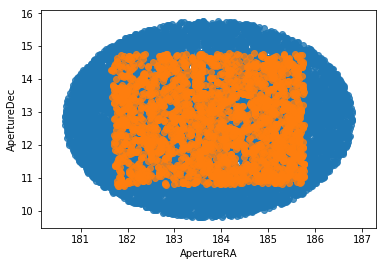

In [13]:
#ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False)

In [19]:
maxdiff = 0.5 

df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff'])

m = 0
while m<len(df_gaia):
    #print("m = ",m)
    n = 0
    while n<len(df_apt):
        #print("n = ",n)
        if (df_apt['CentroidRA'][n]-df_gaia['ra'][m])**2+(df_apt['CentroidDec'][n]-df_gaia['dec'][m])**2 < maxdiff**2:
            #print("yes!",n)
            df = df.append({'ra': df_gaia['ra'][m], 'dec': df_gaia['dec'][m], \
                            'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][m],\
                            'CentroidRA':df_apt['CentroidRA'][n], 'CentroidDec':df_apt['CentroidDec'][n],\
                            'Magnitude': df_apt['Magnitude'][n], \
                            'diff' : math.sqrt((df_apt['CentroidRA'][n]-df_gaia['ra'][m])**2+\
                                               (df_apt['CentroidDec'][n]-df_gaia['dec'][m])**2),\
                            'Δra': df_gaia['ra'][m] - df_apt['CentroidRA'][n],\
                           'Δdec': df_gaia['dec'][m] - df_apt['CentroidDec'][n]},\
            ignore_index=True)
        n+=1
    m+=1

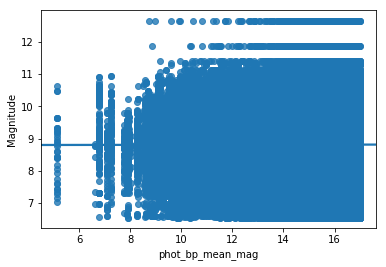

In [21]:
sns.regplot('phot_bp_mean_mag','Magnitude',data=df)

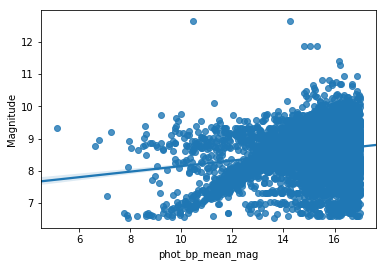

In [23]:
df = df.sort_values('diff').drop_duplicates('ra')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df)

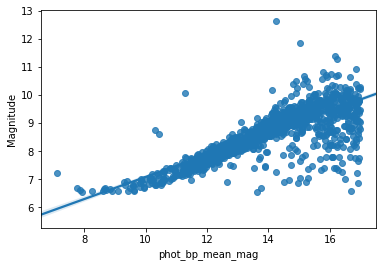

In [24]:
df = df.sort_values('diff').drop_duplicates('CentroidRA')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df)

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


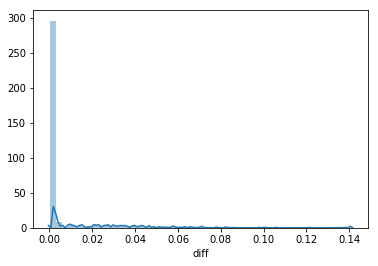

In [25]:
sns.distplot(df['diff'])

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


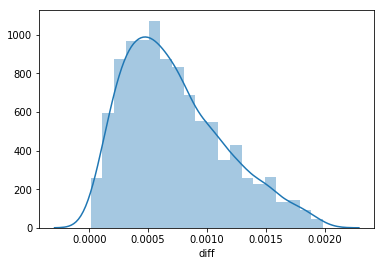

In [34]:
df_filtered = df.query('diff<0.0020')
sns.distplot(df_filtered['diff'])

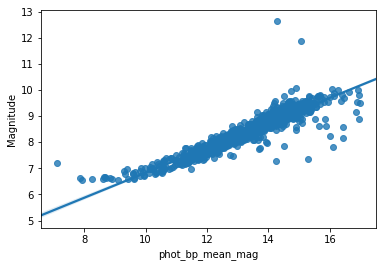

In [36]:
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered)

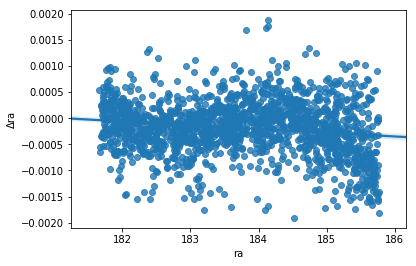

In [37]:
sns.regplot('ra','Δra',data=df_filtered)

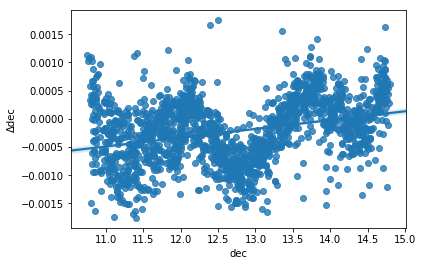

In [38]:
sns.regplot('dec','Δdec',data=df_filtered)

,ra,dec,phot_bp_mean_mag,CentroidRA,CentroidDec,Magnitude,diff,Δdec,Δra
479622,184.070820,14.372645,14.150941,184.070827,14.372656,8.8492,0.000013,-1.099086e-05,-0.000007
228641,183.320503,13.243808,12.436380,183.320489,13.243807,8.0089,0.000014,8.970352e-07,0.000014
215809,183.818579,13.543018,13.027739,183.818583,13.542989,8.1871,0.000030,2.931726e-05,-0.000004
458163,183.152523,14.563906,13.467902,183.152544,14.563881,8.4836,0.000033,2.538993e-05,-0.000021
425727,185.068575,14.186426,13.875167,185.068543,14.186409,8.6501,0.000036,1.691589e-05,0.000032
84099,183.088687,11.122038,15.216256,183.088666,11.122070,9.4292,0.000038,-3.153581e-05,0.000021
395933,184.785448,14.356566,12.568696,184.785470,14.356530,8.2454,0.000043,3.627798e-05,-0.000022
60470,182.214826,11.419771,13.742667,182.214787,11.419793,8.4326,0.000045,-2.156131e-05,0.000039
212910,182.566376,13.182770,14.014671,182.566384,13.182814,8.9026,0.000045,-4.430812e-05,-0.000008
399751,185.428635,14.435731,11.422362,185.428683,14.435727,7.4928,0.000049,4.071446e-06,-0.000048
